# Exogenous Causal Forest

In [42]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 10000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + X[:, [0]] + np.random.normal(0, 1, size=(n_samples, 1))
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [43]:
from econml.grf import CausalForest
est = CausalForest(criterion='mse', n_estimators=1000, min_samples_leaf=20,
                   min_impurity_decrease = 0, max_samples=0.9,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [44]:
est.fit(X, T, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: A column-vector T was passed when a 1d array was expected. Please change the shape of T to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


CausalForest(min_impurity_decrease=0, min_samples_leaf=20, n_estimators=1000,
             n_jobs=-1, random_state=1235)

In [45]:
lb, ub = est.predict_interval(X_test)

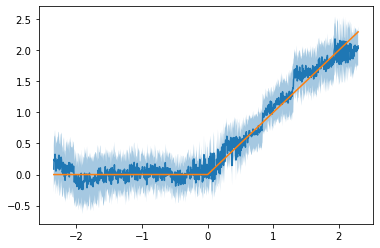

In [46]:
import matplotlib.pyplot as plt
pred_test_point = est.predict(X_test)
for t in range(n_treatments):
    plt.plot(X_test[:, 0], pred_test_point[:, t])
    plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

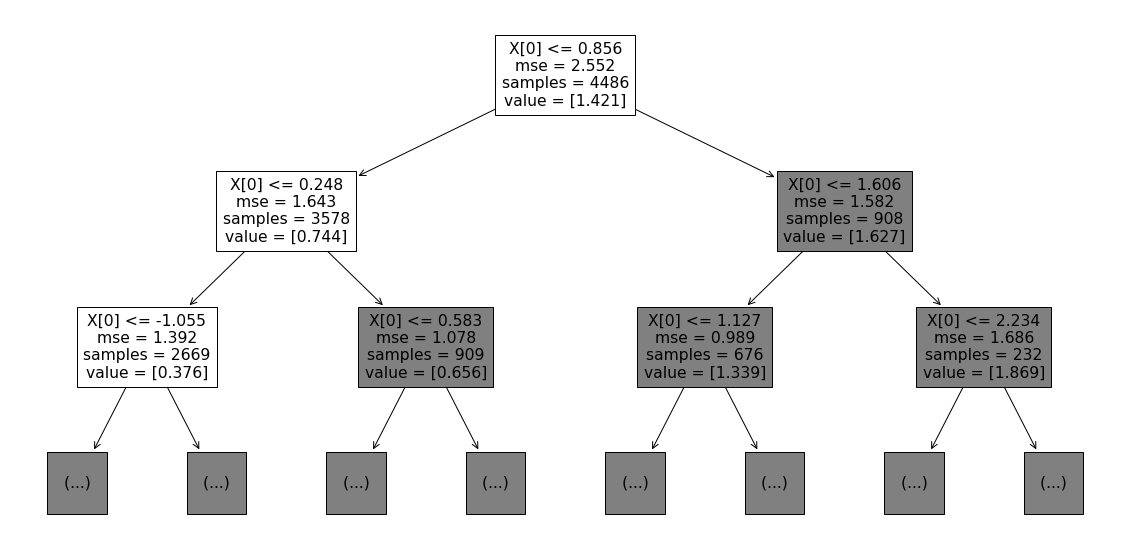

In [47]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[1], impurity=True, max_depth=2)
plt.show()

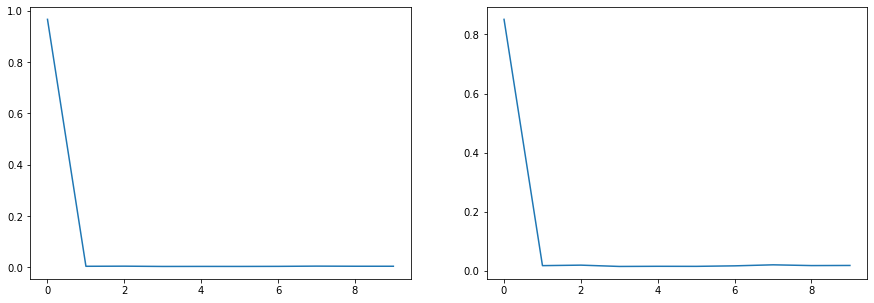

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [49]:
est.decision_path(X_test[:1])

(<1x314350 sparse matrix of type '<class 'numpy.int64'>'
 	with 7532 stored elements in Compressed Sparse Row format>,
 array([     0,    303,    618, ..., 313700, 314023, 314350], dtype=int32))

In [50]:
est.apply(X_test[:1])

array([[ 6,  6,  6,  7,  7,  9, 12, 15,  7,  7,  9,  7,  6,  6,  8,  7,
         5,  8,  8,  7,  5,  6,  7,  6, 11,  7, 13,  8, 12,  9,  7,  9,
         9,  8,  7, 10,  7,  6, 13,  6,  8,  7,  7,  6,  7,  6,  6, 10,
         7,  8,  7,  7,  9,  7,  7,  8,  7,  8, 11, 11,  7,  9,  7,  7,
        14,  6,  9,  6,  6,  7,  7, 10, 10,  6,  7,  8,  7,  6,  8,  6,
         9,  7,  6,  8,  8,  8,  6,  7,  6,  8,  8,  7,  7,  9,  6,  7,
         7,  6,  6,  9,  6,  7,  7, 12,  7,  8,  6,  7,  7,  7,  8,  5,
        10, 14, 11,  7,  6,  6,  9,  7,  7,  6,  8,  6,  7,  7,  9,  8,
         6,  8,  9,  8,  7,  7, 13,  8, 15,  7,  8,  6,  9,  7,  6,  9,
         6,  9,  7,  7,  6,  7,  6,  6,  6, 17,  7,  7,  6,  8,  8,  7,
         7,  6,  8,  6,  8, 17,  9,  8,  7,  7,  6,  8,  7,  9,  6, 11,
         6,  6,  8,  6,  9,  7,  7,  8, 10,  7,  7, 13,  7,  7,  6,  7,
         7,  6, 10,  6,  7,  7,  8,  8,  6, 10,  6,  8,  6,  9,  6,  8,
         9,  8,  6,  6,  6,  8,  9,  7,  7,  7,  6,  7,  7,  8, 

# IV Causal Forest

In [27]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 1000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [34]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=1000, min_samples_leaf=20,
                   min_impurity_decrease = 0.001, max_samples=.9, max_depth=None,
                   honest=True, verbose=0, n_jobs=-1, random_state=123)

In [35]:
est.fit(X, T, y, Z=Z)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: A column-vector T was passed when a 1d array was expected. Please change the shape of T to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\econml\grf\_forest_classes.py:274: UserWarning: A column-vector Z was passed when a 1d array was expected. Please change the shape of Z to (n_samples,), for example using ravel().
  alpha = self.get_alpha(X, Taug, y, **kwargs)


CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=20,
               n_estimators=1000, n_jobs=-1, random_state=123)

In [36]:
lb, ub = est.predict_interval(X_test)

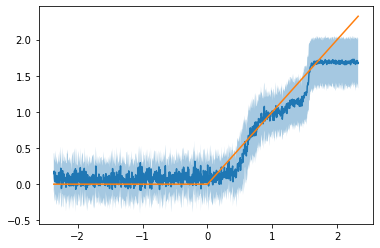

In [37]:
import matplotlib.pyplot as plt
pred_test_point = est.predict(X_test)
for t in range(n_treatments):
    plt.plot(X_test[:, 0], pred_test_point[:, t])
    plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

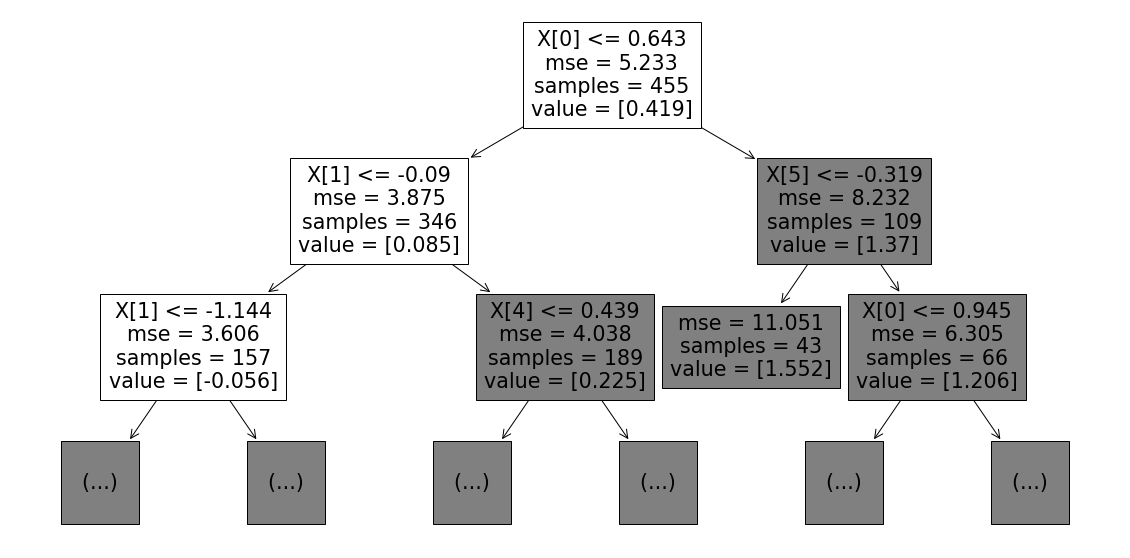

In [38]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

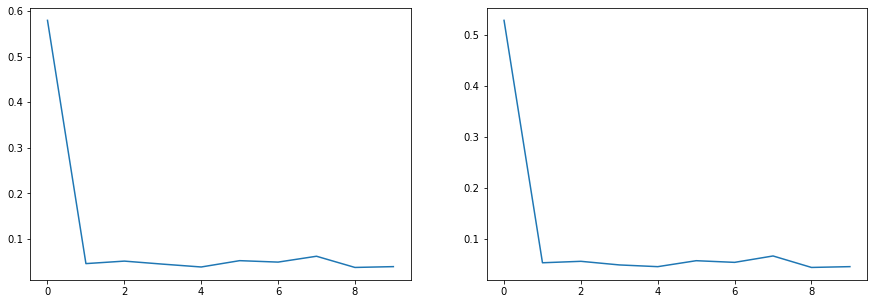

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(est.feature_importances_)
plt.subplot(1, 2, 2)
plt.plot(est.feature_heterogeneity_importances_)
plt.show()

In [40]:
est[0].decision_path(X_test[:1])

<1x31 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [41]:
est[0].apply(X_test[:1])

array([7], dtype=int64)